PUBLICATION NOTE: This code is designed for a comprehensive customer churn prediction analysis, including data preprocessing, feature engineering, model training, hyperparameter tuning, evaluation, and explainability using SHAP. The results are saved in a structured output directory for easy access and reproducibility.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
import warnings
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix,
                           accuracy_score, precision_score, recall_score, f1_score,
                           roc_curve, precision_recall_curve, auc)
from scipy.stats import wilcoxon, friedmanchisquare
import joblib
from imblearn.over_sampling import SMOTE

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create output directory
OUTPUT_DIR = "rill_final"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/plots", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/data", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/models", exist_ok=True)

print("="*80)
print("CUSTOMER CHURN PREDICTION ANALYSIS")
print("="*80)
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Output directory: {OUTPUT_DIR}")

# === STEP 1: DATA LOADING AND EXPLORATION ===
print("\n" + "="*50)
print("STEP 1: DATA LOADING AND EXPLORATION")
print("="*50)

try:
    df = pd.read_csv("dataset/WA_Fn-UseC_-Telco-Customer-Churn_cleaned.csv")
    print(f"✓ Dataset loaded successfully")
    print(f"Dataset shape: {df.shape}")

    # Basic dataset information
    print(f"\nDataset Info:")
    print(f"- Total samples: {len(df)}")
    print(f"- Total features: {len(df.columns)}")
    print(f"- Missing values: {df.isnull().sum().sum()}")

except FileNotFoundError:
    print("❌ Dataset file not found. Please check the file path.")
    exit()


C:\Users\ACER NITRO\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUSTOMER CHURN PREDICTION ANALYSIS
Analysis started at: 2025-06-18 17:52:26
Output directory: rill_final

STEP 1: DATA LOADING AND EXPLORATION
✓ Dataset loaded successfully
Dataset shape: (7043, 21)

Dataset Info:
- Total samples: 7043
- Total features: 21
- Missing values: 0



STEP 2: DATA PREPROCESSING
✓ Column names normalized
Processing TotalCharges column...
Missing values in TotalCharges: 0
✓ Removed 0 rows with missing values
Final dataset shape: (7043, 21)
✓ Customer ID column removed

Target Variable Distribution:
- No: 5174 (73.46%)
- Yes: 1869 (26.54%)


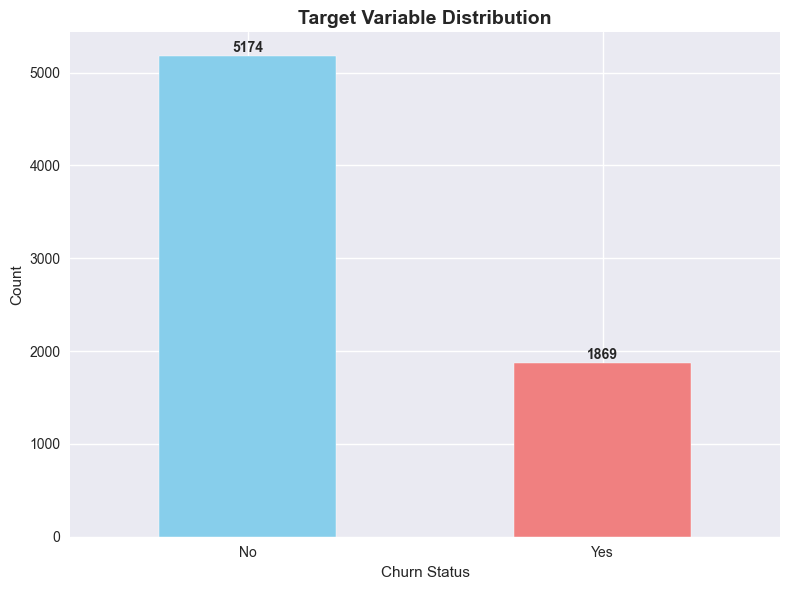

In [2]:

# === STEP 2: DATA PREPROCESSING ===
print("\n" + "="*50)
print("STEP 2: DATA PREPROCESSING")
print("="*50)

# Normalize column names
df.columns = df.columns.str.strip().str.replace(" ", "_")
print("✓ Column names normalized")

# Handle TotalCharges conversion
print("Processing TotalCharges column...")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
missing_before = df['TotalCharges'].isnull().sum()
print(f"Missing values in TotalCharges: {missing_before}")

# Remove rows with missing values
df.dropna(inplace=True)
print(f"✓ Removed {missing_before} rows with missing values")
print(f"Final dataset shape: {df.shape}")

# Remove customer ID
if 'customerID' in df.columns:
    df.drop(['customerID'], axis=1, inplace=True)
    print("✓ Customer ID column removed")

# Analyze target variable distribution
target_dist = df['Churn'].value_counts()
print(f"\nTarget Variable Distribution:")
for label, count in target_dist.items():
    percentage = (count / len(df)) * 100
    print(f"- {label}: {count} ({percentage:.2f}%)")

# Create class distribution plot
plt.figure(figsize=(8, 6))
target_dist.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Target Variable Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, v in enumerate(target_dist.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/target_distribution.png", dpi=300, bbox_inches='tight')
plt.show()



STEP 3: FEATURE ENGINEERING
✓ Added Engagement_Score feature
✓ Added Service_Utilization feature
✓ Added Payment_Reliability feature
Categorical features to encode: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
✓ One-hot encoding completed
Features after encoding: 33
Final feature matrix shape: (7043, 33)
Target variable shape: (7043,)


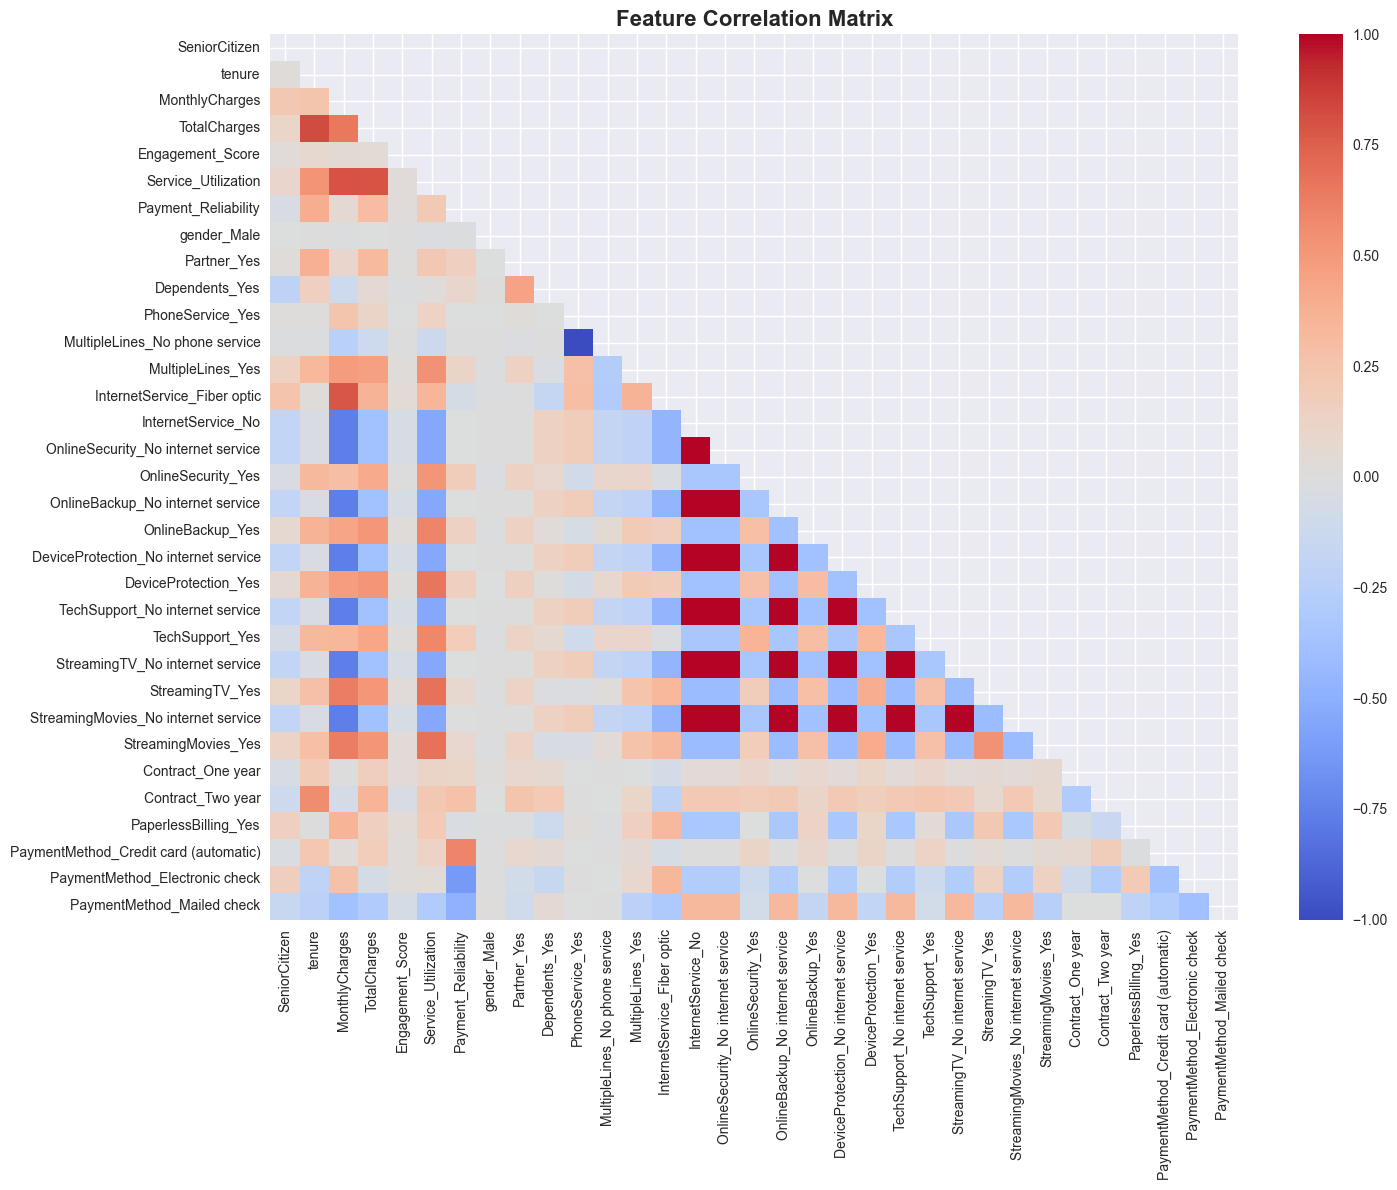

In [3]:

# === STEP 3: FEATURE ENGINEERING ===
print("\n" + "="*50)
print("STEP 3: FEATURE ENGINEERING")
print("="*50)

# New feature: Engagement Score
df['Engagement_Score'] = df['tenure'] * df['MonthlyCharges'] / (df['TotalCharges'] + 1)
print("✓ Added Engagement_Score feature")

# New feature: Service Utilization
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['Service_Utilization'] = df[service_cols].eq('Yes').sum(axis=1)
print("✓ Added Service_Utilization feature")

# New feature: Payment Reliability
df['Payment_Reliability'] = df['PaymentMethod'].apply(
    lambda x: 1 if x in ['Bank transfer (automatic)', 'Credit card (automatic)'] else 0
)
print("✓ Added Payment_Reliability feature")

# One-hot encoding for categorical variables
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
if 'Churn' in categorical_features:
    categorical_features.remove('Churn')

print(f"Categorical features to encode: {categorical_features}")
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
print(f"✓ One-hot encoding completed")
print(f"Features after encoding: {df_encoded.shape[1] - 1}")

# Prepare features and target
X = df_encoded.drop("Churn", axis=1)
y = (df_encoded["Churn"] == "Yes").astype(int)  # Convert to binary

print(f"Final feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Feature correlation analysis
plt.figure(figsize=(15, 12))
corr_matrix = X.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

In [4]:
# === STEP 4: DATA SCALING AND SPLITTING ===
print("\n" + "="*50)
print("STEP 4: DATA SCALING AND SPLITTING")
print("="*50)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("✓ Feature scaling completed")

# Save scaler
joblib.dump(scaler, f"{OUTPUT_DIR}/models/scaler.pkl")
print("✓ Scaler saved")

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_scaled_res, y_res = smote.fit_resample(X_scaled, y)
print(f"✓ SMOTE applied - Resampled dataset shape: {X_scaled_res.shape}")
print(f"Resampled target distribution: {np.bincount(y_res)}")

# Train-test split on resampled data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_res, y_res, stratify=y_res, test_size=0.25, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")



STEP 4: DATA SCALING AND SPLITTING
✓ Feature scaling completed
✓ Scaler saved
✓ SMOTE applied - Resampled dataset shape: (10348, 33)
Resampled target distribution: [5174 5174]
Training set shape: (7761, 33)
Testing set shape: (2587, 33)
Training set class distribution: [3880 3881]
Testing set class distribution: [1294 1293]


In [5]:

# === STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING ===
print("\n" + "="*50)
print("STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING")
print("="*50)

# Define models with expanded hyperparameter grids
models_config = {
    "GBM": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'min_samples_leaf': [5, 10]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            'n_estimators': [100, 200, 500, 1000],
            'learning_rate': [0.01, 0.05, 0.1, 0.3],
            'max_depth': [3, 5, 7, 10],
            'subsample': [0.6, 0.8, 1.0]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'n_estimators': [100, 200, 500],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            'C': [0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    },
    "SVC": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear']
        }
    },
    "NeuralNet": {
        "model": MLPClassifier(max_iter=1000, random_state=42),
        "params": {
            'hidden_layer_sizes': [(100,), (100, 50), (50, 50)],
            'alpha': [0.001, 0.01, 0.1]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            'n_estimators': [50, 100, 200, 500],
            'learning_rate': [0.1, 0.5, 1.0]
        }
    }
}

# Perform hyperparameter tuning
print("Performing hyperparameter tuning...")
tuned_models = {}
tuning_results = []

for name, config in models_config.items():
    print(f"Tuning {name}...")
    grid_search = GridSearchCV(
        config["model"],
        config["params"],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        return_train_score=True
    )
    grid_search.fit(X_train, y_train)
    tuned_models[name] = grid_search.best_estimator_
    print(f"✓ {name} best score: {grid_search.best_score_:.4f}")
    print(f"Best parameters: {grid_search.best_params_}")

    # Save tuning results
    tuning_results.append({
        'Model': name,
        'Best_Score': grid_search.best_score_,
        'Best_Params': grid_search.best_params_,
        'CV_Results': grid_search.cv_results_
    })

# Save tuning results
tuning_df = pd.DataFrame({
    'Model': [res['Model'] for res in tuning_results],
    'Best_Score': [res['Best_Score'] for res in tuning_results],
    'Best_Params': [res['Best_Params'] for res in tuning_results]
})
tuning_df.to_csv(f"{OUTPUT_DIR}/data/hyperparameter_tuning_results.csv", index=False)
print("✓ Hyperparameter tuning results saved")



STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING
Performing hyperparameter tuning...
Tuning GBM...
✓ GBM best score: 0.9319
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 10, 'n_estimators': 200}
Tuning XGBoost...
✓ XGBoost best score: 0.9325
Best parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.8}
Tuning RandomForest...
✓ RandomForest best score: 0.9215
Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}
Tuning LogisticRegression...
✓ LogisticRegression best score: 0.8569
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Tuning SVC...
✓ SVC best score: 0.9074
Best parameters: {'C': 10, 'kernel': 'rbf'}
Tuning NeuralNet...
✓ NeuralNet best score: 0.8975
Best parameters: {'alpha': 0.1, 'hidden_layer_sizes': (100, 50)}
Tuning AdaBoost...
✓ AdaBoost best score: 0.9191
Best parameters: {'learning_rate': 1.0, 'n_estimators': 500}
✓ Hyperparameter tuning results saved



STEP 6: CROSS-VALIDATION EVALUATION
Performing 10-fold cross-validation...
--------------------------------------------------------------------------------
Model           ROC-AUC      Accuracy   Precision  Recall     F1-Score  
--------------------------------------------------------------------------------
GBM             0.9368±0.008 0.8563±0.011 0.8552±0.016 0.8583±0.018 0.8566±0.011
XGBoost         0.9376±0.009 0.8578±0.014 0.8503±0.018 0.8692±0.020 0.8594±0.014
RandomForest    0.9317±0.009 0.8623±0.010 0.8490±0.016 0.8819±0.015 0.8650±0.010
LogisticRegression 0.8595±0.012 0.7770±0.015 0.7566±0.019 0.8175±0.018 0.7857±0.014
SVC             0.9189±0.012 0.8440±0.015 0.8165±0.019 0.8881±0.016 0.8507±0.013
NeuralNet       0.9103±0.012 0.8447±0.015 0.8219±0.026 0.8819±0.015 0.8505±0.012
AdaBoost        0.9216±0.009 0.8375±0.013 0.8214±0.015 0.8630±0.022 0.8414±0.013
✓ Cross-validation metrics per fold saved


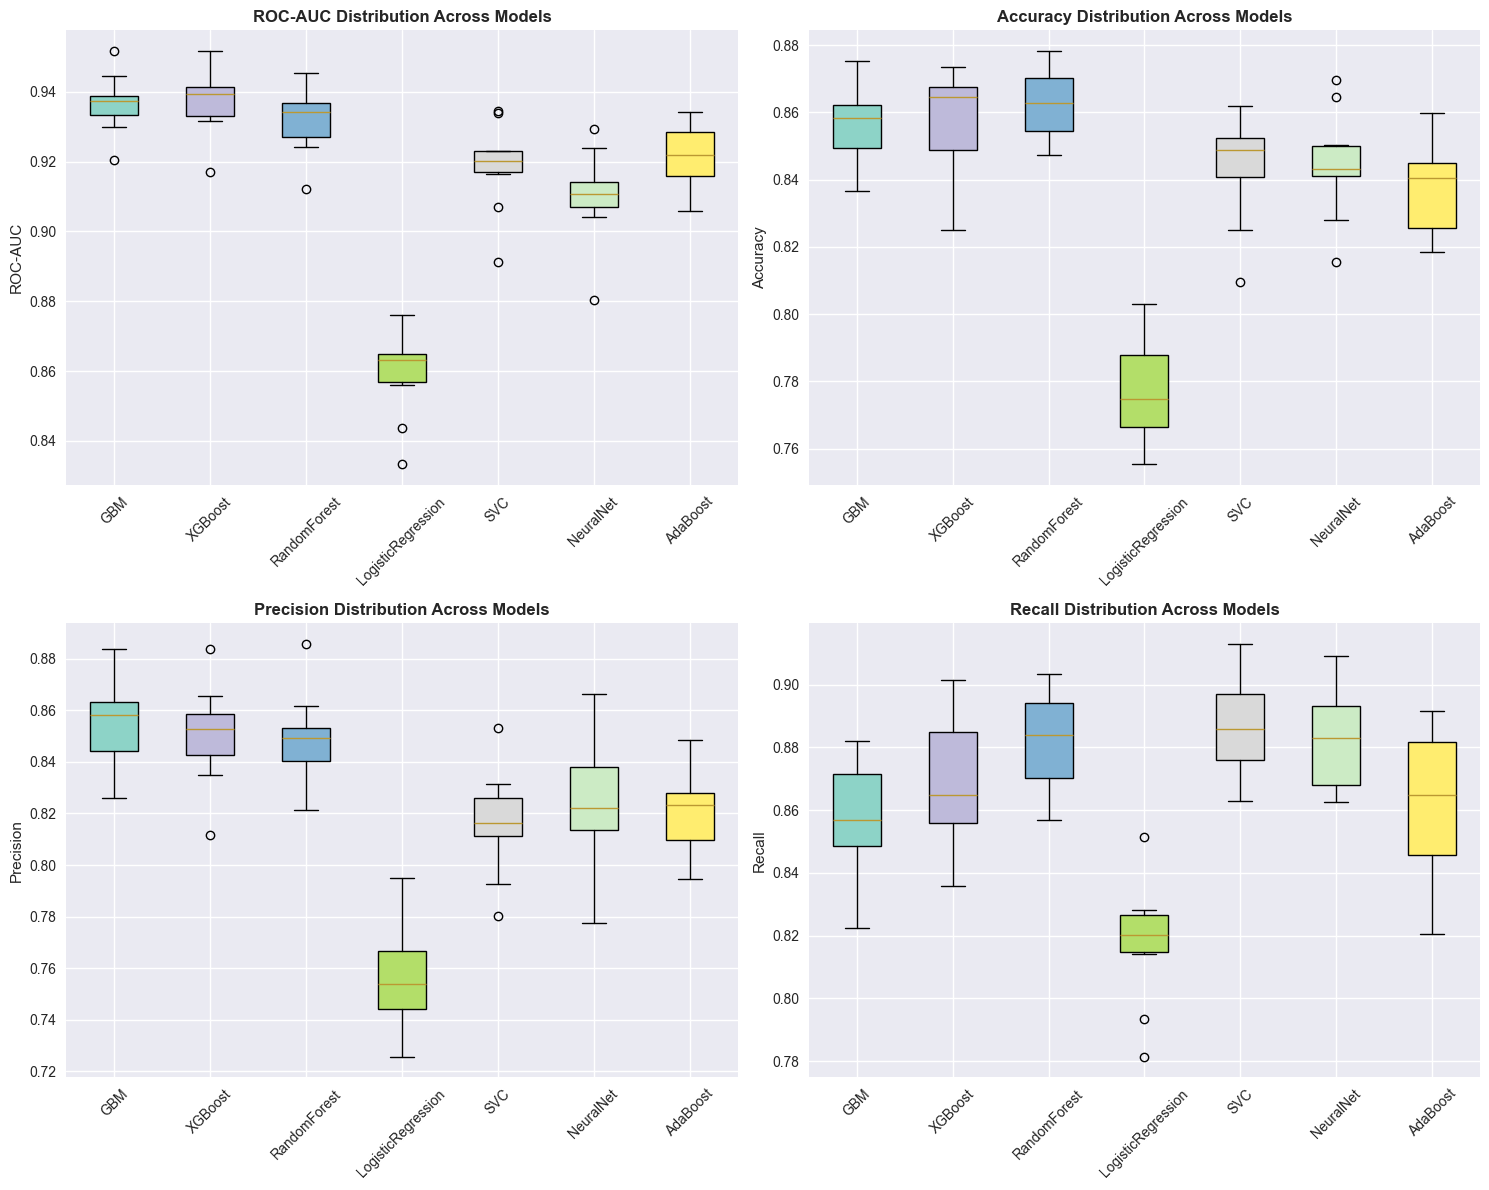

In [6]:

# === STEP 6: CROSS-VALIDATION EVALUATION ===
print("\n" + "="*50)
print("STEP 6: CROSS-VALIDATION EVALUATION")
print("="*50)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results = {}
metrics_results = {}
cv_metrics_per_fold = {}

print("Performing 10-fold cross-validation...")
print("-" * 80)
print(f"{'Model':<15} {'ROC-AUC':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 80)

for name, model in tuned_models.items():
    cv_metrics_per_fold[name] = {'roc_auc': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    for train_idx, val_idx in cv.split(X_scaled_res, y_res):
        X_cv_train, X_cv_val = X_scaled_res[train_idx], X_scaled_res[val_idx]
        y_cv_train, y_cv_val = y_res[train_idx], y_res[val_idx]

        model.fit(X_cv_train, y_cv_train)
        y_pred = model.predict(X_cv_val)
        y_pred_proba = model.predict_proba(X_cv_val)[:, 1]

        cv_metrics_per_fold[name]['roc_auc'].append(roc_auc_score(y_cv_val, y_pred_proba))
        cv_metrics_per_fold[name]['accuracy'].append(accuracy_score(y_cv_val, y_pred))
        cv_metrics_per_fold[name]['precision'].append(precision_score(y_cv_val, y_pred))
        cv_metrics_per_fold[name]['recall'].append(recall_score(y_cv_val, y_pred))
        cv_metrics_per_fold[name]['f1'].append(f1_score(y_cv_val, y_pred))

    roc_scores = np.array(cv_metrics_per_fold[name]['roc_auc'])
    acc_scores = np.array(cv_metrics_per_fold[name]['accuracy'])
    prec_scores = np.array(cv_metrics_per_fold[name]['precision'])
    rec_scores = np.array(cv_metrics_per_fold[name]['recall'])
    f1_scores = np.array(cv_metrics_per_fold[name]['f1'])

    cv_results[name] = roc_scores
    metrics_results[name] = {
        'roc_auc': roc_scores,
        'accuracy': acc_scores,
        'precision': prec_scores,
        'recall': rec_scores,
        'f1': f1_scores
    }

    print(f"{name:<15} {roc_scores.mean():.4f}±{roc_scores.std():.3f} "
          f"{acc_scores.mean():.4f}±{acc_scores.std():.3f} "
          f"{prec_scores.mean():.4f}±{prec_scores.std():.3f} "
          f"{rec_scores.mean():.4f}±{rec_scores.std():.3f} "
          f"{f1_scores.mean():.4f}±{f1_scores.std():.3f}")

# Save per-fold metrics
cv_metrics_df = pd.DataFrame({
    'Model': [name for name in cv_metrics_per_fold for _ in range(10)],
    'Fold': list(range(1, 11)) * len(cv_metrics_per_fold),
    'ROC_AUC': [score for name in cv_metrics_per_fold for score in cv_metrics_per_fold[name]['roc_auc']],
    'Accuracy': [score for name in cv_metrics_per_fold for score in cv_metrics_per_fold[name]['accuracy']],
    'Precision': [score for name in cv_metrics_per_fold for score in cv_metrics_per_fold[name]['precision']],
    'Recall': [score for name in cv_metrics_per_fold for score in cv_metrics_per_fold[name]['recall']],
    'F1': [score for name in cv_metrics_per_fold for score in cv_metrics_per_fold[name]['f1']]
})
cv_metrics_df.to_csv(f"{OUTPUT_DIR}/data/cv_metrics_per_fold.csv", index=False)
print("✓ Cross-validation metrics per fold saved")

# Create performance comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics = ['roc_auc', 'accuracy', 'precision', 'recall']
titles = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx//2, idx%2]
    data = [metrics_results[model][metric] for model in tuned_models.keys()]
    labels = list(tuned_models.keys())

    bp = ax.boxplot(data, labels=labels, patch_artist=True)
    ax.set_title(f'{title} Distribution Across Models', fontweight='bold')
    ax.set_ylabel(title)
    ax.tick_params(axis='x', rotation=45)

    colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


In [7]:

# === STEP 7: STATISTICAL SIGNIFICANCE TESTING ===
print("\n" + "="*50)
print("STEP 7: STATISTICAL SIGNIFICANCE TESTING")
print("="*50)

# Wilcoxon signed-rank test (pairwise comparison)
print("Wilcoxon Signed-Rank Test Results:")
print("-" * 50)
best_model = max(cv_results.keys(), key=lambda k: cv_results[k].mean())
print(f"Best performing model (baseline): {best_model}")
print(f"Baseline ROC-AUC: {cv_results[best_model].mean():.4f} ± {cv_results[best_model].std():.4f}")
print()

baseline_scores = cv_results[best_model]
significance_results = {}

for name, scores in cv_results.items():
    if name != best_model:
        stat, p_value = wilcoxon(baseline_scores, scores, alternative='two-sided')
        significance_results[name] = p_value
        significance = "" if p_value < 0.001 else "" if p_value < 0.01 else "" if p_value < 0.05 else "ns"
        print(f"{name:<15} vs {best_model}: p-value = {p_value:.6f} {significance}")

# Friedman test for multiple model comparison
print(f"\nFriedman Test (Multiple Model Comparison):")
all_scores = [scores for scores in cv_results.values()]
friedman_stat, friedman_p = friedmanchisquare(*all_scores)
print(f"Friedman statistic: {friedman_stat:.4f}")
print(f"p-value: {friedman_p:.6f}")



STEP 7: STATISTICAL SIGNIFICANCE TESTING
Wilcoxon Signed-Rank Test Results:
--------------------------------------------------
Best performing model (baseline): XGBoost
Baseline ROC-AUC: 0.9376 ± 0.0089

GBM             vs XGBoost: p-value = 0.322266 ns
RandomForest    vs XGBoost: p-value = 0.001953 
LogisticRegression vs XGBoost: p-value = 0.001953 
SVC             vs XGBoost: p-value = 0.001953 
NeuralNet       vs XGBoost: p-value = 0.001953 
AdaBoost        vs XGBoost: p-value = 0.001953 

Friedman Test (Multiple Model Comparison):
Friedman statistic: 55.7143
p-value: 0.000000



STEP 8: FINAL MODEL EVALUATION
Final Model Performance (XGBoost):
----------------------------------------
ACCURACY  : 0.8535
PRECISION : 0.8457
RECALL    : 0.8647
F1        : 0.8551
ROC_AUC   : 0.9342

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1294
           1       0.85      0.86      0.86      1293

    accuracy                           0.85      2587
   macro avg       0.85      0.85      0.85      2587
weighted avg       0.85      0.85      0.85      2587



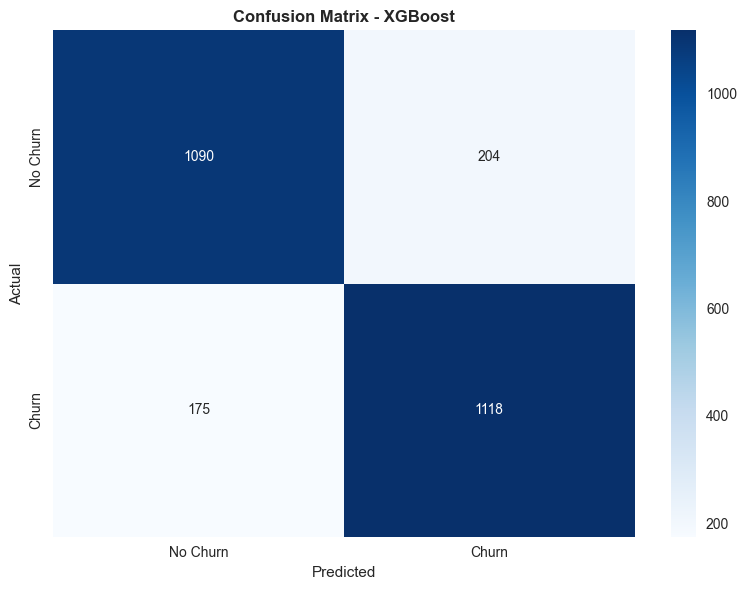

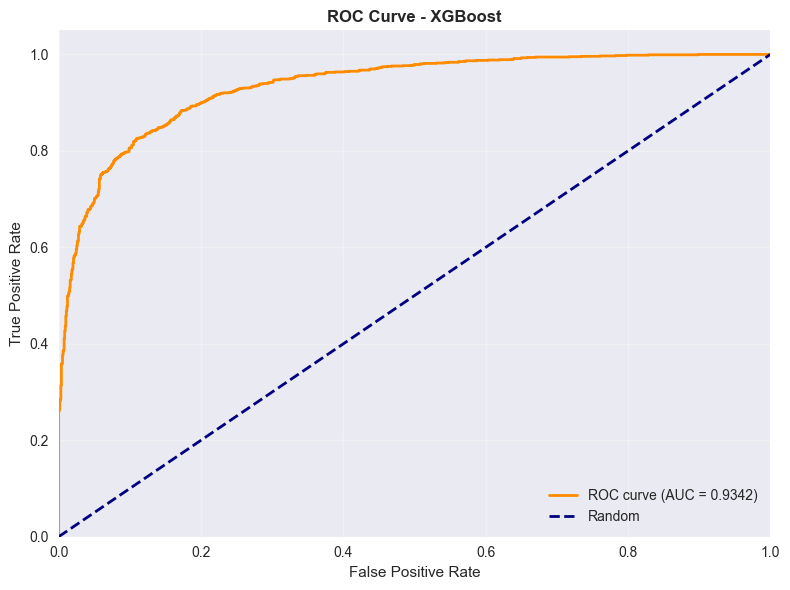

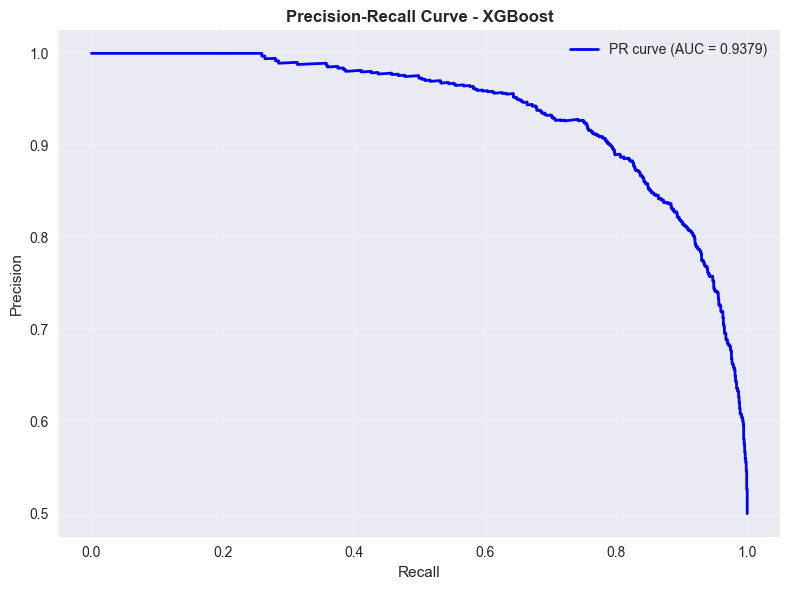

✓ Final model saved as XGBoost
✓ Test predictions saved for external validation


In [8]:

# === STEP 8: FINAL MODEL EVALUATION ===
print("\n" + "="*50)
print("STEP 8: FINAL MODEL EVALUATION")
print("="*50)

# Train the best model on full training set
final_model = tuned_models[best_model]
final_model.fit(X_train, y_train)

# Predictions
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Calculate comprehensive metrics
test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_pred_proba)
}

print(f"Final Model Performance ({best_model}):")
print("-" * 40)
for metric, value in test_metrics.items():
    print(f"{metric.upper():<10}: {value:.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {best_model}', fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model}', fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {best_model}', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/precision_recall_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# Save the final model
joblib.dump(final_model, f"{OUTPUT_DIR}/models/final_model.pkl")
print(f"✓ Final model saved as {best_model}")

# Save predictions for external validation
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Probability': y_pred_proba
})
predictions_df.to_csv(f"{OUTPUT_DIR}/data/test_predictions.csv", index=False)
print("✓ Test predictions saved for external validation")


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



STEP 9: SHAP EXPLAINABILITY ANALYSIS
Generating SHAP explanations...


100%|██████████| 200/200 [02:57<00:00,  1.12it/s]


background_data shape: (200, 33)
test_data shape: (200, 33)
X.columns shape: (33,)
shap_values shape: (200, 33)


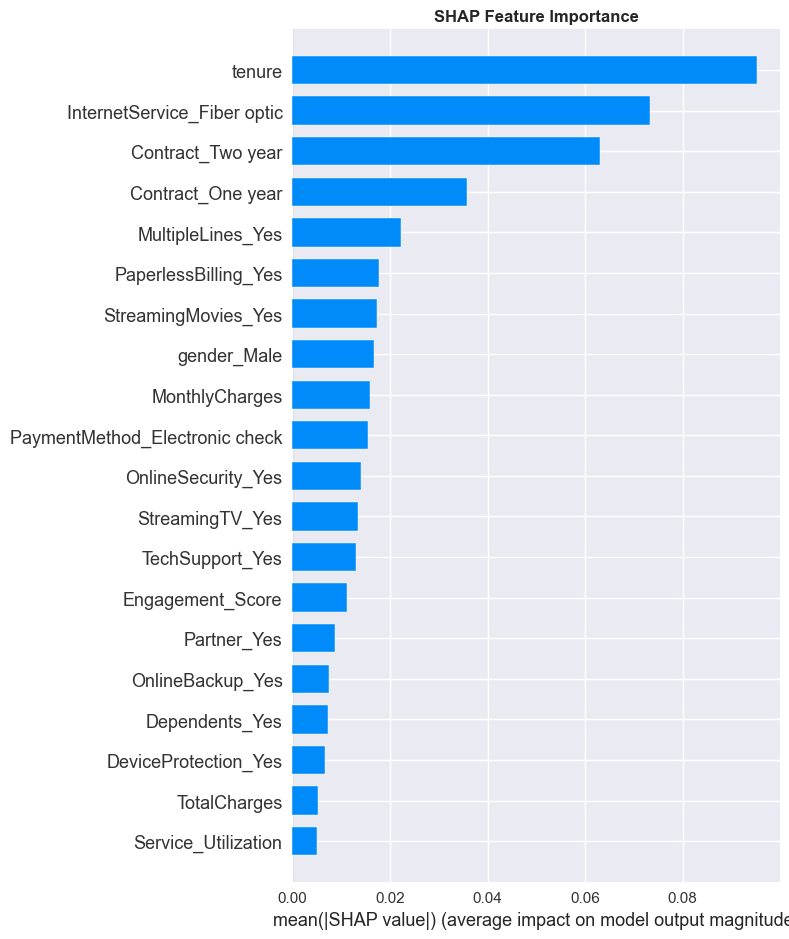

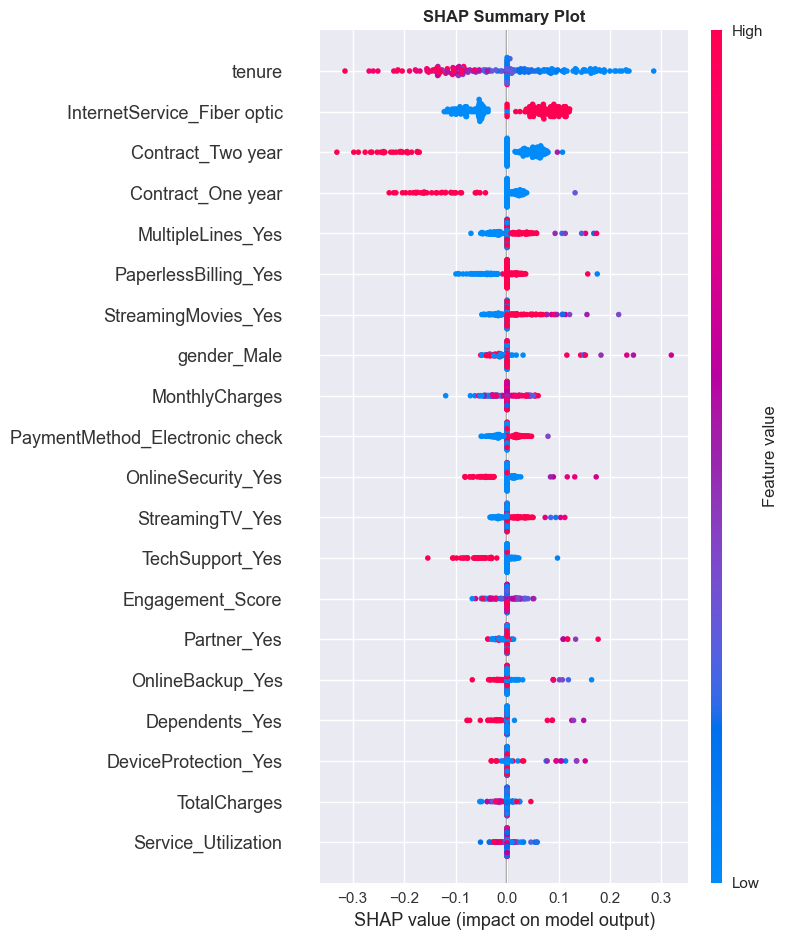

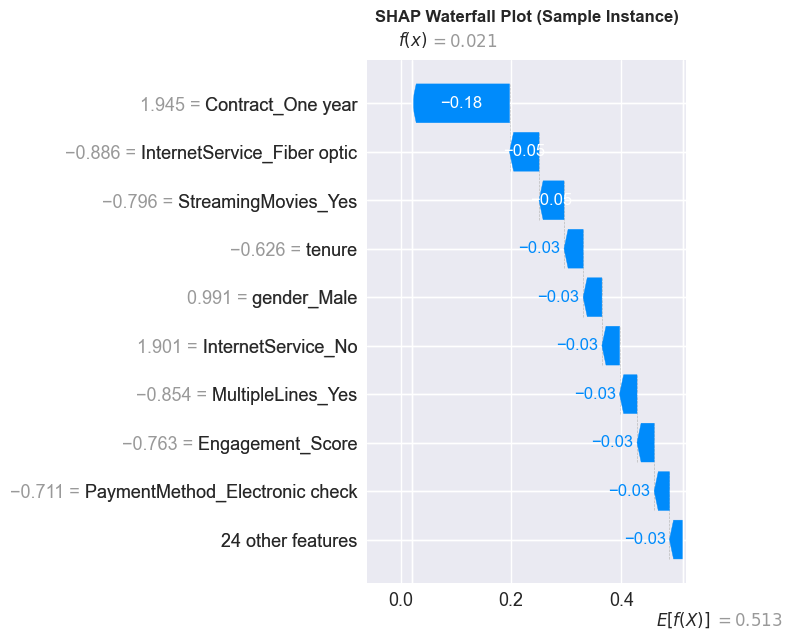

<Figure size 1000x800 with 0 Axes>

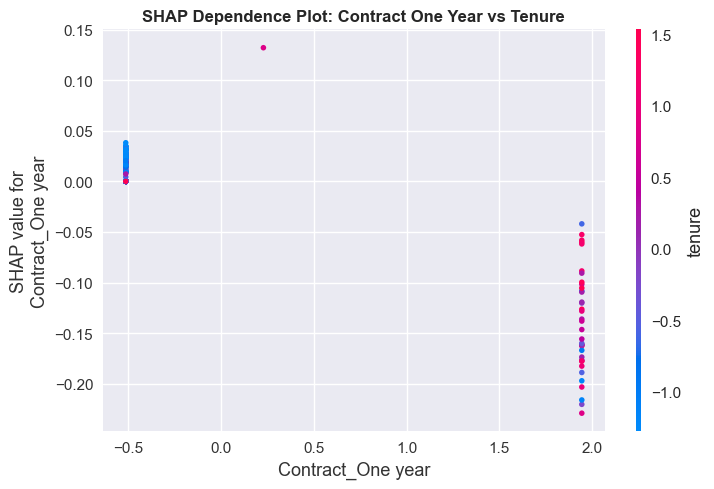

In [9]:

# === STEP 9: SHAP EXPLAINABILITY ANALYSIS ===
print("\n" + "="*50)
print("STEP 9: SHAP EXPLAINABILITY ANALYSIS")
print("="*50)

print("Generating SHAP explanations...")
n_samples = 200  # Increased sample size
background_data = X_train[:n_samples]
test_data = X_test[:n_samples]

explainer = shap.KernelExplainer(lambda x: final_model.predict_proba(x)[:, 1], background_data)
shap_values = explainer.shap_values(test_data)

# Debug shapes
print("background_data shape:", background_data.shape)
print("test_data shape:", test_data.shape)
print("X.columns shape:", X.columns.shape)
print("shap_values shape:", shap_values.shape)

# Ensure feature names match
features_df = pd.DataFrame(test_data, columns=X.columns)

# Feature importance plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values=shap_values, features=features_df, plot_type="bar", show=False)
plt.title('SHAP Feature Importance', fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/shap_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

# SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, features=features_df, show=False)
plt.title('SHAP Summary Plot', fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/shap_summary.png", dpi=300, bbox_inches='tight')
plt.show()

# SHAP waterfall plot for first instance
plt.figure(figsize=(10, 8))
shap.waterfall_plot(shap.Explanation(
    values=shap_values[0],
    base_values=explainer.expected_value,
    data=test_data[0],
    feature_names=X.columns.tolist()
), show=False)
plt.title('SHAP Waterfall Plot (Sample Instance)', fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/shap_waterfall.png", dpi=300, bbox_inches='tight')
plt.show()

# SHAP dependence plot for feature interaction
plt.figure(figsize=(10, 8))
shap.dependence_plot('Contract_One year', shap_values, features_df,  # Ganti ke 'Contract_One year'
                     interaction_index='tenure', show=False)
plt.title('SHAP Dependence Plot: Contract One Year vs Tenure', fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/shap_dependence_contract_tenure.png", dpi=300, bbox_inches='tight')
plt.show()


In [10]:
print("Kolom yang tersedia di features_df:", features_df.columns.tolist())

Kolom yang tersedia di features_df: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Engagement_Score', 'Service_Utilization', 'Payment_Reliability', 'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


In [11]:

# === STEP 10: SAVE RESULTS AND DATA ===
print("\n" + "="*50)
print("STEP 10: SAVING RESULTS AND DATA")
print("="*50)

# Save cross-validation results
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.to_csv(f"{OUTPUT_DIR}/data/cv_results.csv", index=False)
print("✓ Cross-validation results saved")

# Save comprehensive metrics
metrics_df = pd.DataFrame({
    'Model': list(tuned_models.keys()),
    'ROC_AUC_mean': [metrics_results[m]['roc_auc'].mean() for m in tuned_models.keys()],
    'ROC_AUC_std': [metrics_results[m]['roc_auc'].std() for m in tuned_models.keys()],
    'Accuracy_mean': [metrics_results[m]['accuracy'].mean() for m in tuned_models.keys()],
    'Accuracy_std': [metrics_results[m]['accuracy'].std() for m in tuned_models.keys()],
    'Precision_mean': [metrics_results[m]['precision'].mean() for m in tuned_models.keys()],
    'Precision_std': [metrics_results[m]['precision'].std() for m in tuned_models.keys()],
    'Recall_mean': [metrics_results[m]['recall'].mean() for m in tuned_models.keys()],
    'Recall_std': [metrics_results[m]['recall'].std() for m in tuned_models.keys()],
    'F1_mean': [metrics_results[m]['f1'].mean() for m in tuned_models.keys()],
    'F1_std': [metrics_results[m]['f1'].std() for m in tuned_models.keys()]
})
metrics_df.to_csv(f"{OUTPUT_DIR}/data/model_performance_metrics.csv", index=False)
print("✓ Model performance metrics saved")

# Save statistical test results
stats_df = pd.DataFrame({
    'Model': list(significance_results.keys()),
    'Wilcoxon_p_value': list(significance_results.values()),
    'Significant_at_0.05': [p < 0.05 for p in significance_results.values()]
})
stats_df.to_csv(f"{OUTPUT_DIR}/data/statistical_tests.csv", index=False)
print("✓ Statistical test results saved")

# Save final test metrics
final_metrics_df = pd.DataFrame([test_metrics])
final_metrics_df.to_csv(f"{OUTPUT_DIR}/data/final_model_metrics.csv", index=False)
print("✓ Final model metrics saved")

# Save feature names
feature_names_df = pd.DataFrame({'Feature': X.columns})
feature_names_df.to_csv(f"{OUTPUT_DIR}/data/feature_names.csv", index=False)
print("✓ Feature names saved")

# Save processed dataset
df_processed = pd.DataFrame(X_scaled_res, columns=X.columns)
df_processed['target'] = y_res
df_processed.to_csv(f"{OUTPUT_DIR}/data/processed_dataset.csv", index=False)
print("✓ Processed dataset saved")

# === ANALYSIS SUMMARY ===
print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)
print(f"✓ Dataset: {df.shape} → {X_scaled_res.shape} (after preprocessing and SMOTE)")
print(f"✓ Best Model: {best_model} (ROC-AUC: {cv_results[best_model].mean():.4f})")
print(f"✓ Test Performance: {test_metrics['roc_auc']:.4f} ROC-AUC")
print(f"✓ Statistical Tests: Wilcoxon & Friedman completed")
print(f"✓ SHAP Analysis: Feature importance, summary, waterfall, and dependence plots generated")
print(f"✓ All outputs saved to: {OUTPUT_DIR}/")
print(f"  - Plots: {len(os.listdir(f'{OUTPUT_DIR}/plots'))} files")
print(f"  - Data: {len(os.listdir(f'{OUTPUT_DIR}/data'))} files")
print(f"  - Models: {len(os.listdir(f'{OUTPUT_DIR}/models'))} files")
print(f"\nAnalysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

# Display final metrics table for journal
print("\nFINAL RESULTS TABLE (For Journal Publication):")
print("="*80)
print(metrics_df.round(4).to_string(index=False))
print("="*80)


STEP 10: SAVING RESULTS AND DATA
✓ Cross-validation results saved
✓ Model performance metrics saved
✓ Statistical test results saved
✓ Final model metrics saved
✓ Feature names saved
✓ Processed dataset saved

ANALYSIS SUMMARY
✓ Dataset: (7043, 23) → (10348, 33) (after preprocessing and SMOTE)
✓ Best Model: XGBoost (ROC-AUC: 0.9376)
✓ Test Performance: 0.9342 ROC-AUC
✓ Statistical Tests: Wilcoxon & Friedman completed
✓ SHAP Analysis: Feature importance, summary, waterfall, and dependence plots generated
✓ All outputs saved to: rill_final/
  - Plots: 10 files
  - Data: 9 files
  - Models: 2 files

Analysis completed at: 2025-06-18 18:20:16

FINAL RESULTS TABLE (For Journal Publication):
             Model  ROC_AUC_mean  ROC_AUC_std  Accuracy_mean  Accuracy_std  Precision_mean  Precision_std  Recall_mean  Recall_std  F1_mean  F1_std
               GBM        0.9368       0.0078         0.8563        0.0107          0.8552         0.0157       0.8583      0.0178   0.8566  0.0107
        